In [2]:
%%html
<style id=hide>div.input{display:none;}</style>
<button type="button" 
onclick="var myStyle = document.getElementById('hide').sheet;myStyle.insertRule('div.input{display:inherit !important;}', 0);">
Show inputs</button>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy import stats
import arviz as az
import seaborn as sns
import pandas as pd
from theano import shared

## EDA - Post-omicron

In [4]:
post_omi = pd.read_csv('data/post_omi.csv')
post_omi.sample(20)

,Sample_Date,WRRF_Name,Gene Copies (N1/L),Per Capita Gene Copies,"Population Served, estimated",School-Aged Population,Season,Holiday
1414,2022-12-18,Owls Head,48587.00,17000000.00,906442,135396.0,Fall 2022,1
1206,2022-10-11,Jamaica Bay,20599.00,7500000.00,748737,131881.0,Fall 2022,1
612,2022-04-24,Tallman Island,29445.29,12100000.00,449907,74748.0,Spring 2022,0
433,2022-03-13,26th Ward,438.65,286000.00,290608,72091.0,Winter 2021,0
890,2022-07-12,Red Hook,22469.00,9490000.00,224029,33636.0,Summer 2022,0
1442,2022-12-27,Owls Head,50279.00,17200000.00,906442,135396.0,Winter 2022,0
1483,2023-01-17,Oakwood Beach,19872.96,7070000.00,258731,44374.0,Winter 2022,0
204,2022-01-10,Owls Head,53904.00,19584504.61,906442,135396.0,Winter 2021,0
1096,2022-09-06,North River,6813.00,6740000.00,658596,72242.0,Summer 2022,0
655,2022-05-03,Wards Island,11303.71,6130000.00,1201485,240219.0,Spring 2022,0


In [5]:
# Double-checking data 
post_omi.isnull().sum()

Sample_Date                     0
WRRF_Name                       0
Gene Copies (N1/L)              0
Per Capita Gene Copies          0
Population Served, estimated    0
School-Aged Population          0
Season                          0
Holiday                         0
dtype: int64

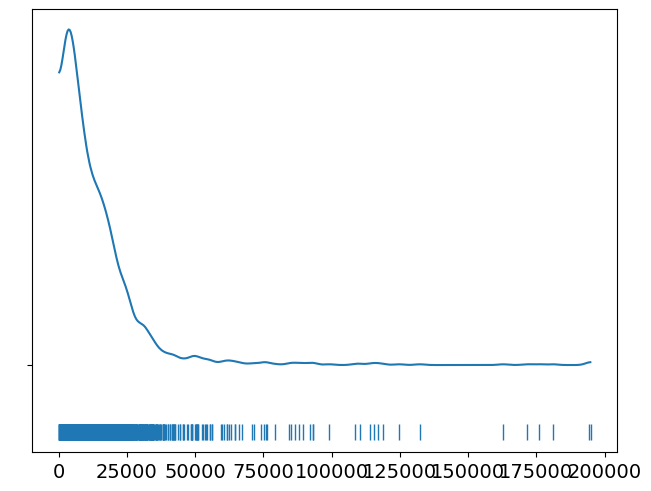

In [6]:
# Non-log-transformed target shape
az.plot_kde(post_omi['Gene Copies (N1/L)'].values, rug=True)
plt.yticks([0], alpha=0);

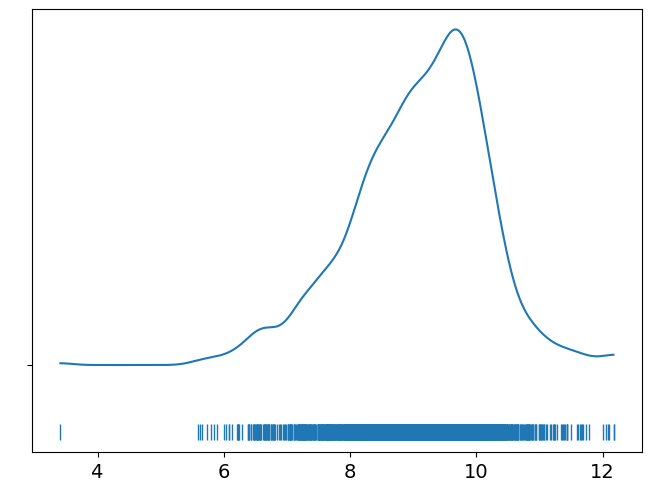

In [7]:
# log-transformed target shape
post_omi_logs = np.log(post_omi['Gene Copies (N1/L)'].values)
az.plot_kde(post_omi_logs, rug=True)
plt.yticks([0], alpha=0);

In [8]:
# Getting min and max to set as mu priors
post_omi_min = min(post_omi_logs)
post_omi_max = max(post_omi_logs)
data = {'Min Value': [post_omi_min], 'Max Value': [post_omi_max]}
df = pd.DataFrame(data)
df.head()

,Min Value,Max Value
0,3.401197,12.180642


/var/folders/yf/9lmqvqdx2h3d7cgwxqhp7bnc0000gn/T/ipykernel_91829/2706306424.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_g = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


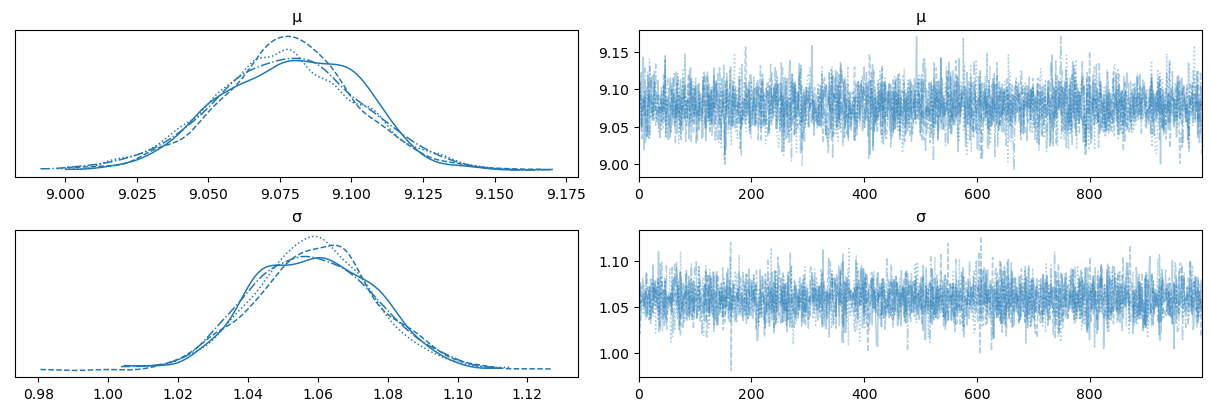

In [9]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=3.4, upper=12.18)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=post_omi_logs)
    trace_g = pm.sample(1000, tune=1000)

az.plot_trace(trace_g);

In [10]:
with model_g:
    summary = pm.summary(trace_g, hdi_prob=0.94)  # 94% HPD
print(summary)


    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail   
μ  9.078  0.025   9.030    9.122        0.0      0.0    3228.0    2560.0  \
σ  1.059  0.018   1.026    1.092        0.0      0.0    3343.0    2470.0   

   r_hat  
μ    1.0  
σ    1.0  


In [11]:
# Good convergence (r_hat) and low error (msce) so looks like our posteriors are pretty good!

/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


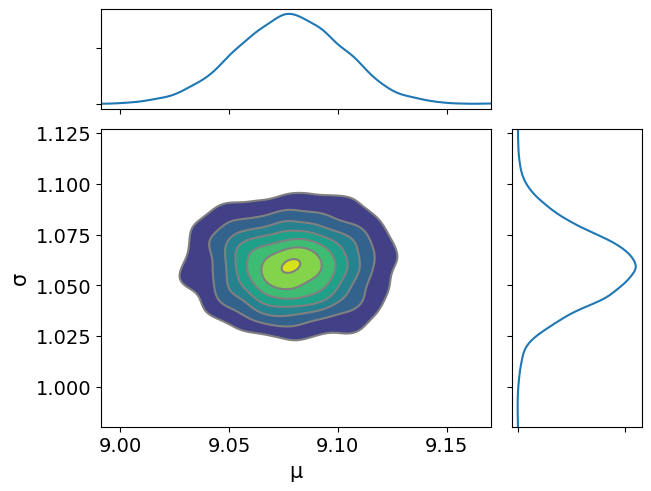

In [12]:
az.plot_joint(trace_g, kind='kde', fill_last=False);

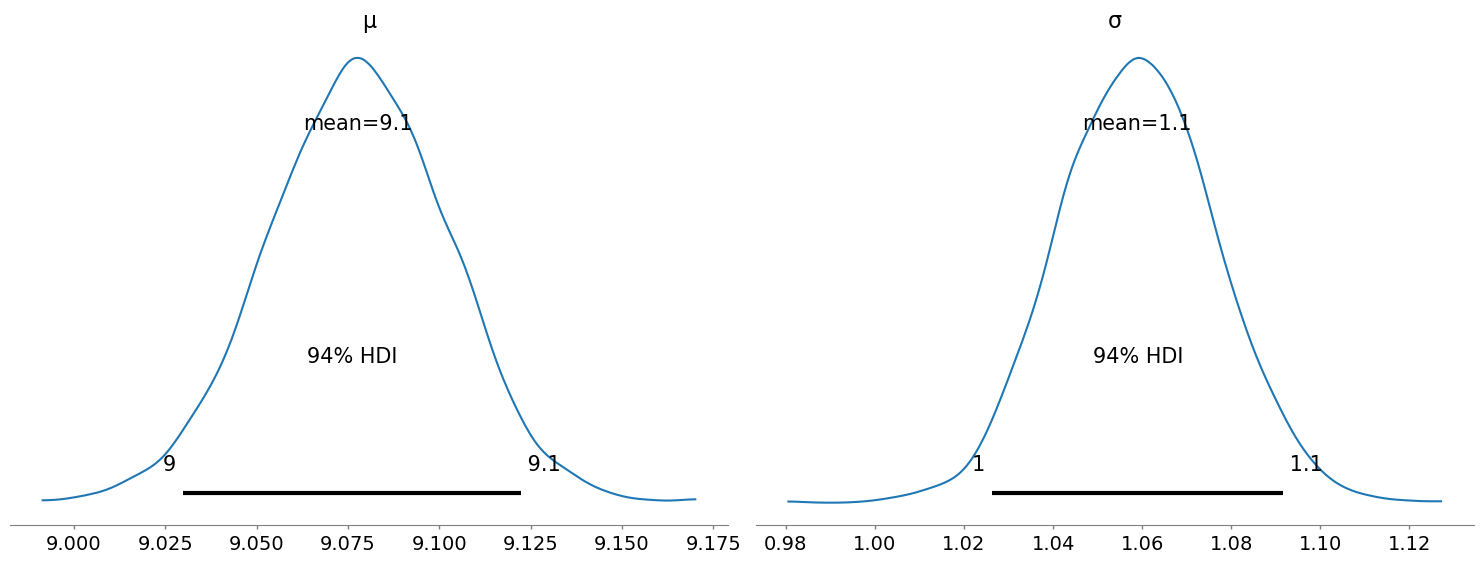

In [13]:
# Separately normally distributed mu and sigma, circular kde, so looks good! mu and sigma are seemingly independent.

az.plot_posterior(trace_g);

/var/folders/yf/9lmqvqdx2h3d7cgwxqhp7bnc0000gn/T/ipykernel_91829/3035545975.py:10: DeprecationWarning: The function `energyplot` from PyMC3 is just an alias for `plot_energy` from ArviZ. Please switch to `pymc3.plot_energy` or `arviz.plot_energy`.
  pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr))
/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


(1000, 1784)

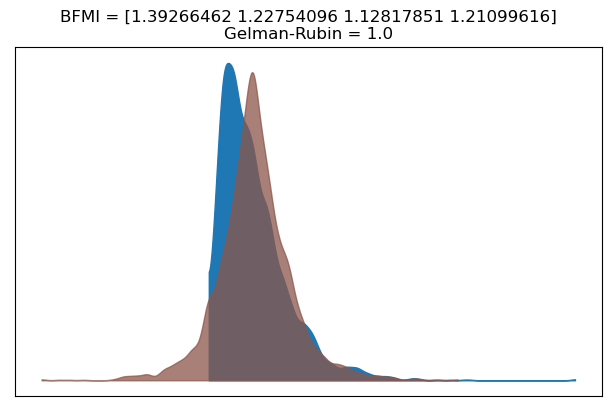

In [14]:
bfmi = pm.bfmi(trace_g)

# get gelman-rubin
summary = pm.summary(trace_g, hdi_prob=0.94)  # 0.94 for a 94% Highest Density Interval (HDI)

# extract gelman-rubin
max_gr = summary['r_hat'].max()


pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr))

ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model=model_g)
np.asarray(ppc['y']).shape

9.077718436039726


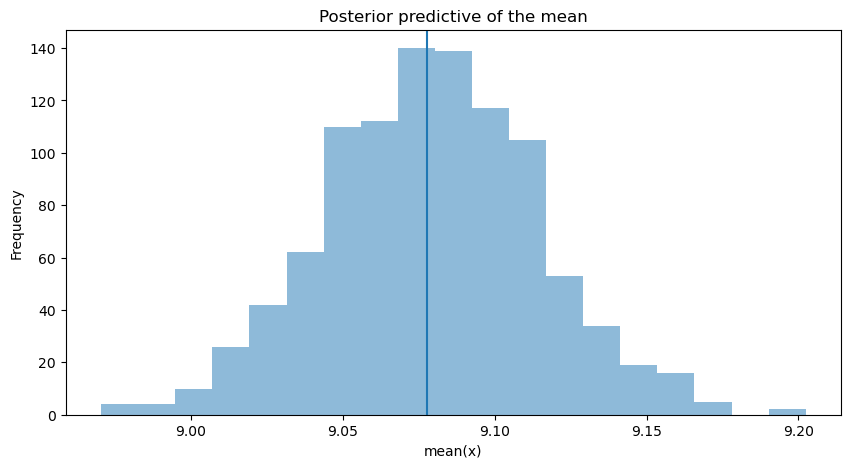

In [30]:
# Plotting histogram of predictive mean
mean = np.mean(post_omi_logs)
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(mean)
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');
print(mean)

In [29]:
# Inferred very close to actual mean! Our posteriors seem pretty solid. 


# Let's break down our target data by categorical data. Will also try with continuous.

wrrf_names = post_omi['WRRF_Name'].values
wrrf_names = set(list(wrrf_names))
for name in wrrf_names:
    print(name)

Coney Island
Tallman Island
Newtown Creek
North River
Port Richmond
Hunts Point
Red Hook
26th Ward
Rockaway
Owls Head
Wards Island
Jamaica Bay
Bowery Bay
Oakwood Beach


In [30]:

target = post_omi_logs.copy()
idx = pd.Categorical(post_omi['WRRF_Name'],
                     categories=['26th Ward', 'Bowery Bay', 'Coney Island', 'Hunts Point', 'Jamaica Bay', 
                                 'North River', 'Oakwood Beach','Newtown Creek', 'Owls Head',
                                'Port Richmond', 'Red Hook', 'Rockaway', 'Tallman Island', 'Wards Island']).codes
groups = len(np.unique(idx))

In [31]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=5, shape=groups) # lower mu since expecting variation between min and max
    σ = pm.HalfNormal('σ', sd=2, shape=groups) # higher sd since less certainty between groups

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=target)

    trace_groups = pm.sample(5000, tune=5000)

/var/folders/yf/9lmqvqdx2h3d7cgwxqhp7bnc0000gn/T/ipykernel_76463/3369262307.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_groups = pm.sample(5000, tune=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 41 seconds.


In [32]:
ww_by_site = az.from_pymc3(trace=trace_groups)
ww_gaussian = az.summary(ww_by_site)
ww_gaussian

/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],8.730,0.098,8.548,8.917,0.001,0.0,33954.0,14755.0,1.0
μ[1],9.423,0.082,9.271,9.575,0.000,0.0,38058.0,14815.0,1.0
μ[2],9.068,0.084,8.913,9.227,0.000,0.0,39595.0,14787.0,1.0
μ[3],8.574,0.105,8.380,8.774,0.001,0.0,36854.0,15135.0,1.0
μ[4],9.382,0.103,9.180,9.571,0.001,0.0,36340.0,15224.0,1.0
μ[5],8.964,0.089,8.800,9.133,0.000,0.0,39456.0,14902.0,1.0
μ[6],9.002,0.088,8.838,9.169,0.000,0.0,37075.0,14645.0,1.0
μ[7],9.094,0.080,8.936,9.239,0.000,0.0,39622.0,14266.0,1.0
μ[8],9.485,0.084,9.332,9.649,0.000,0.0,37977.0,15796.0,1.0
μ[9],9.206,0.085,9.049,9.369,0.000,0.0,35078.0,13999.0,1.0


In [33]:
# Our priors are very strong! We can have high certainty in our regression models. This matches our assumption of relatively uniform distributions
# of the mean by facility post-Omicron, given that there was a sudden, massive uptick across the board that in turn, 
# (we assume), spread just about everywhere *and* that this uniform spread persisted over time given
# the resumption in-person work and schooling, the ending of mandates, and the general dispersion of the population given mass
# transit, commuting, nightlife, etc. We assume timing of waves will vary given individual population characteristics
# by facility but given a wide enough timespan (in this case, about 1.5 years) the mean will be fairly consistent.

In [34]:
# Let's try generating sample predictions for each wastewater site: 

with comparing_groups:
    posterior_pred = pm.sample_posterior_predictive(trace_groups, samples=500)


/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


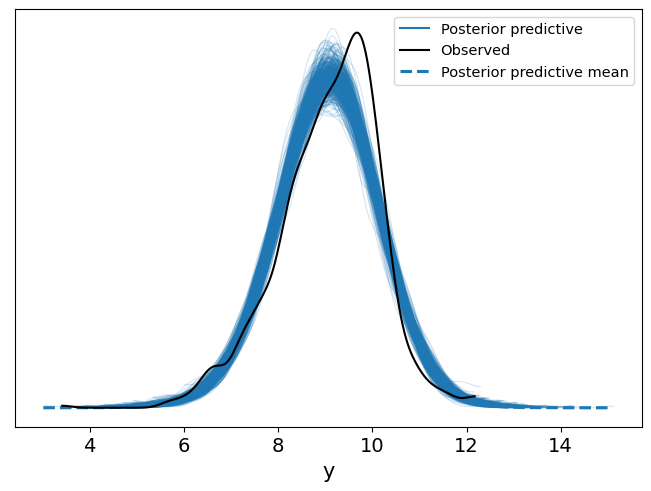

In [35]:
# Convert to arviz's data structure
data_az = az.from_pymc3(trace=trace_groups, posterior_predictive=posterior_pred)

# Plot observed data and posterior predictive means and HDIs
az.plot_ppc(data_az)
plt.show()


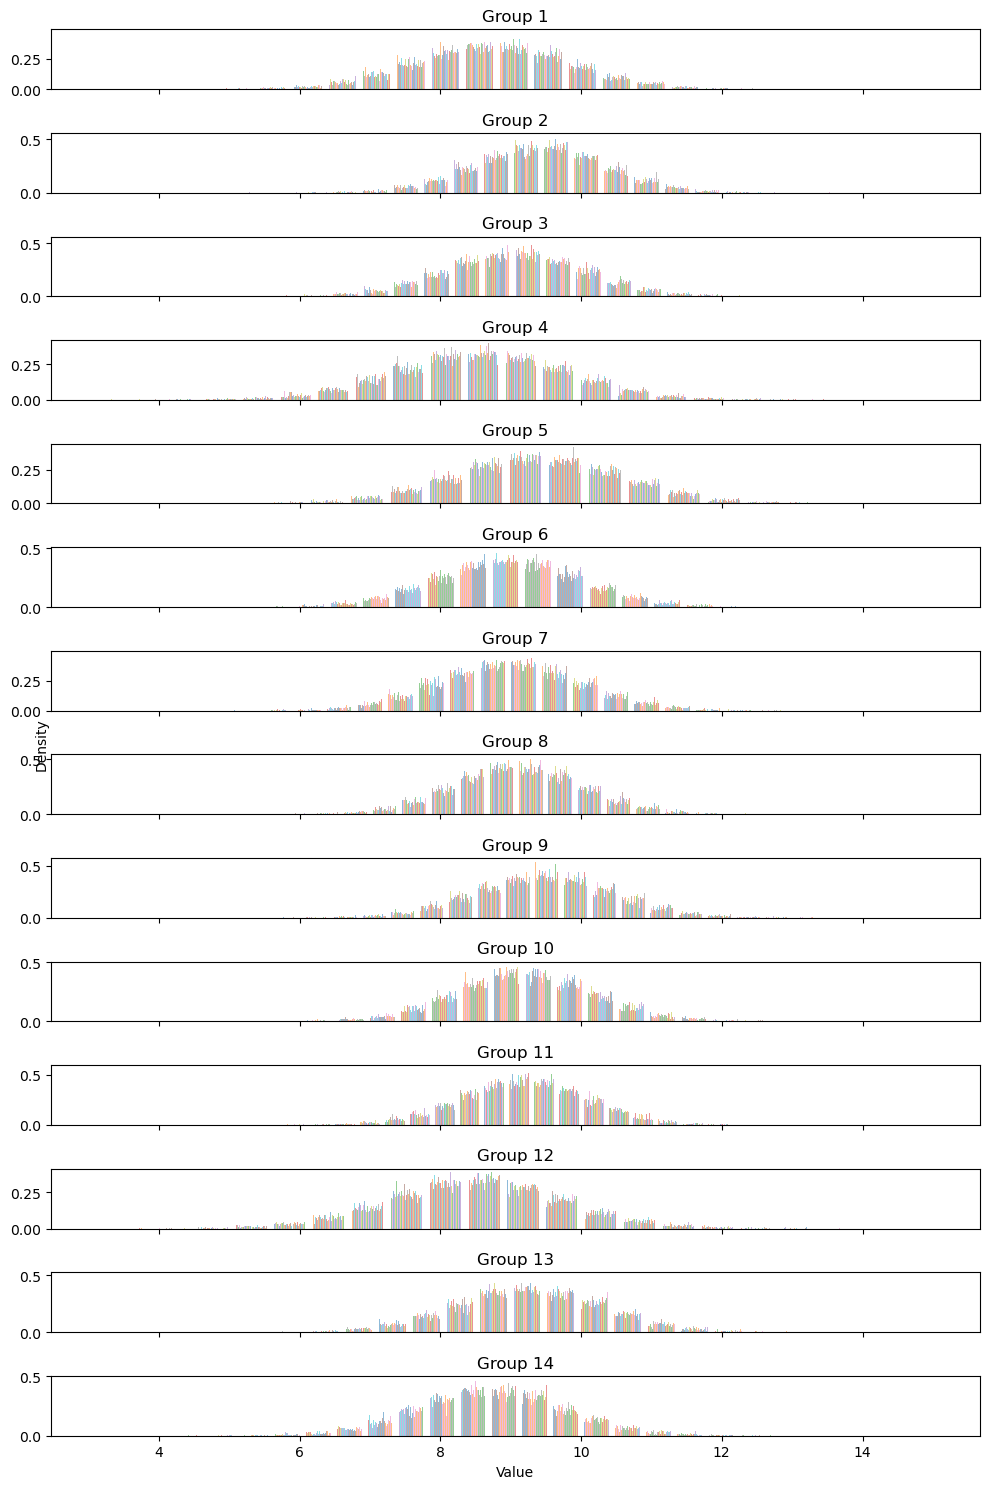

In [36]:
# Define the number of groups
n_groups = len(np.unique(idx))

fig, ax = plt.subplots(n_groups, figsize=(10, 15), sharex=True)

# Loop over each group
for i in range(n_groups):
    # Plot the histogram of the posterior predictive samples
    ax[i].hist(posterior_pred['y'][:, idx==i], bins=20, alpha=0.5, density=True)
    # Set the title of the subplot to the name of the group
    ax[i].set_title(f"Group {i+1}")
    
# Set the x and y labels of the entire plot
ax[-1].set_xlabel("Value")
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

In [39]:
# Now we're going to look at the school-aged population versus the target!

bins = pd.cut(post_omi['School-Aged Population'], bins=4) # converting continuous data to bins
idx = pd.Categorical(bins).codes # getting codes from these bins
groups = len(np.unique(idx)) # sorting these into total number of codes

# Then use idx as before:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=8.5, sd=2, shape=groups)
    σ = pm.HalfNormal('σ', sd=2, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=target)

    trace_groups = pm.sample(5000, tune=5000)



/var/folders/yf/9lmqvqdx2h3d7cgwxqhp7bnc0000gn/T/ipykernel_76463/2539169945.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_groups = pm.sample(5000, tune=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 33 seconds.


In [40]:
ww_by_school_pop = az.from_pymc3(trace=trace_groups)
ww_gaussian = az.summary(ww_by_school_pop)
ww_gaussian

/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],9.012,0.035,8.947,9.080,0.0,0.0,29238.0,16064.0,1.0
μ[1],9.327,0.053,9.229,9.428,0.0,0.0,26980.0,15965.0,1.0
μ[2],9.066,0.074,8.928,9.207,0.0,0.0,27713.0,16269.0,1.0
μ[3],8.941,0.061,8.823,9.054,0.0,0.0,28691.0,16872.0,1.0
σ[0],1.050,0.025,1.004,1.097,0.0,0.0,35528.0,17020.0,1.0
σ[1],1.028,0.037,0.960,1.100,0.0,0.0,30392.0,16124.0,1.0
σ[2],1.173,0.053,1.077,1.276,0.0,0.0,28688.0,16001.0,1.0
σ[3],0.974,0.044,0.894,1.058,0.0,0.0,28785.0,15051.0,1.0


In [42]:
# Overall, very confident in our data! We could compare a few more variables, however.

# Let's look at the population versus the target!

bins = pd.cut(post_omi['Population Served, estimated'], bins=4) # converting continuous data to bins/'categories'
idx = pd.Categorical(bins).codes # getting codes from these bins
groups = len(np.unique(idx)) # sorting these into total number of codes

# Then use idx as before:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=8.5, sd=2, shape=groups)
    σ = pm.HalfNormal('σ', sd=2, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=target)

    trace_groups = pm.sample(5000, tune=5000)


/var/folders/yf/9lmqvqdx2h3d7cgwxqhp7bnc0000gn/T/ipykernel_76463/3601372932.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_groups = pm.sample(5000, tune=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 33 seconds.


In [43]:
ww_by_pop = az.from_pymc3(trace=trace_groups)
ww_gaussian = az.summary(ww_by_pop)
ww_gaussian

/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],8.959,0.042,8.876,9.036,0.0,0.0,27161.0,15706.0,1.0
μ[1],9.141,0.065,9.022,9.264,0.0,0.0,30724.0,16081.0,1.0
μ[2],9.223,0.043,9.140,9.305,0.0,0.0,30707.0,15660.0,1.0
μ[3],8.941,0.062,8.822,9.054,0.0,0.0,33900.0,15295.0,1.0
σ[0],1.057,0.030,1.002,1.113,0.0,0.0,28271.0,16266.0,1.0
σ[1],1.029,0.046,0.942,1.115,0.0,0.0,29644.0,16469.0,1.0
σ[2],1.092,0.031,1.036,1.151,0.0,0.0,37639.0,16096.0,1.0
σ[3],0.975,0.044,0.896,1.060,0.0,0.0,29755.0,16718.0,1.0


In [44]:
# Setting aside some log test data if I later decide to do train and test splits

import random

sample_value = int(len(post_omi_logs) * .2) # test size
post_omi_logs = list(post_omi_logs) # convert to list in order to sample
post_omi_logs_test = random.sample(post_omi_logs, sample_value) # random sampling

post_omi_logs_test = np.array(post_omi_logs_test) # convert to array

post_omi_logs_train = [x for x in post_omi_logs if x not in post_omi_logs_test]
post_omi_logs_train = np.array(post_omi_logs_train) # convert to array
post_omi_logs = np.array(post_omi_logs) # re-convert to array


In [34]:
# Getting RMSE 

# Create array of means from PPCs
ppc_means = np.array([y.mean() for y in ppc['y']])


residuals = ppc_means - np.mean(post_omi_logs)

squared_residuals = residuals ** 2

mean_squared_residual = np.mean(squared_residuals)

rmse = np.sqrt(mean_squared_residual)

print(f'RMSE: {rmse}')
print(f'Actual Mean: {mean}')

RMSE: 0.035047215070211295
Actual Mean: 9.077718436039726


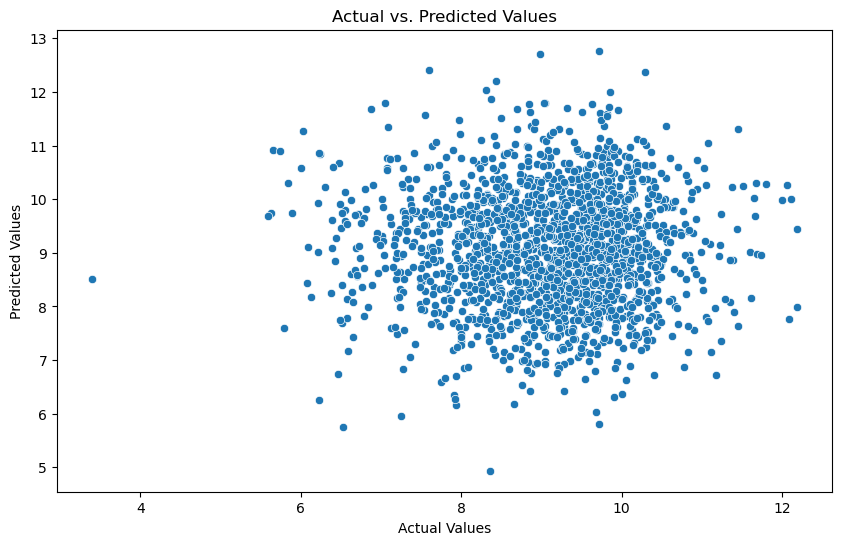

In [53]:
# Select the first 'n' points of actual data, where 'n' is the number of simulated data points
ppc_samples = ppc['y']

actual_data_subset = post_omi_logs[:ppc_samples.shape[1]]

# Select one sample from ppc_samples
ppc_sample = ppc_samples[0, :]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=actual_data_subset, y=ppc_sample)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()


In [58]:
actual_data_mu = np.mean(post_omi_logs)
ppc_mu = np.mean(ppc_samples)
print(f'Mean of Actual Data: {actual_data_mu}')
print(f'Mean of PPC: {ppc_mu}')

Mean of Actual Data: 9.077718436039726
Mean of PPC: 9.079255768917998


In [57]:
actual_data_std = np.std(post_omi_logs)

# Calculate standard deviation of ppc
ppc_std = np.std(ppc_samples)

print(f'Standard deviation of actual data: {actual_data_std}')
print(f'Standard deviation of ppc: {ppc_std}')

Standard deviation of actual data: 1.0583811597801744
Standard deviation of ppc: 1.0581891311614384


# Not good at predicting individual values, but very good at deriving the parameters. 